In [1]:
!pip install -U folium
!pip install -U branca
!pip install geopandas

/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by bash)
/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash

In [2]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re
import requests
import json
import folium

In [3]:
data= pd.read_csv("/project/shanti_data/data.csv")

<AxesSubplot:>

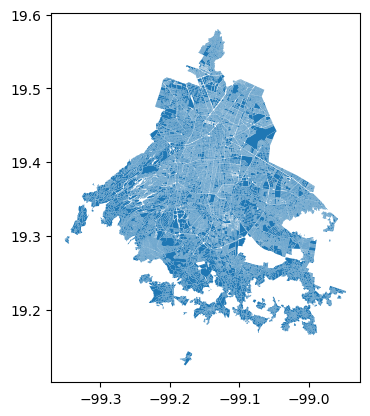

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt

blocks = gpd.read_file('/project/blocks/poligono_manzanas_cdmx.shp')
blocks.plot()

plt.show()

In [ ]:
blocks.set_crs("EPSG:4326", inplace=True)

In [ ]:
from shapely.geometry import Point
# Create a GeoDataFrame from your existing DataFrame

data['geometry'] = data.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(data, geometry='geometry')

# Set the coordinate reference system (CRS) to be the same as the blocks
# This is necessary for the spatial join to work correctly
gdf.set_crs(blocks.crs, inplace=True)

# Perform the spatial join
joined = gpd.sjoin(gdf, blocks, how='left', op='intersects')

# The result is a new GeoDataFrame that includes all columns from the original DataFrame,
# plus additional columns for each attribute in the shapefile for the block that each point falls within.

## Zoom into the Downtown 

<AxesSubplot:>

<AxesSubplot:>

(-99.1, -99.2)

(19.4, 19.5)

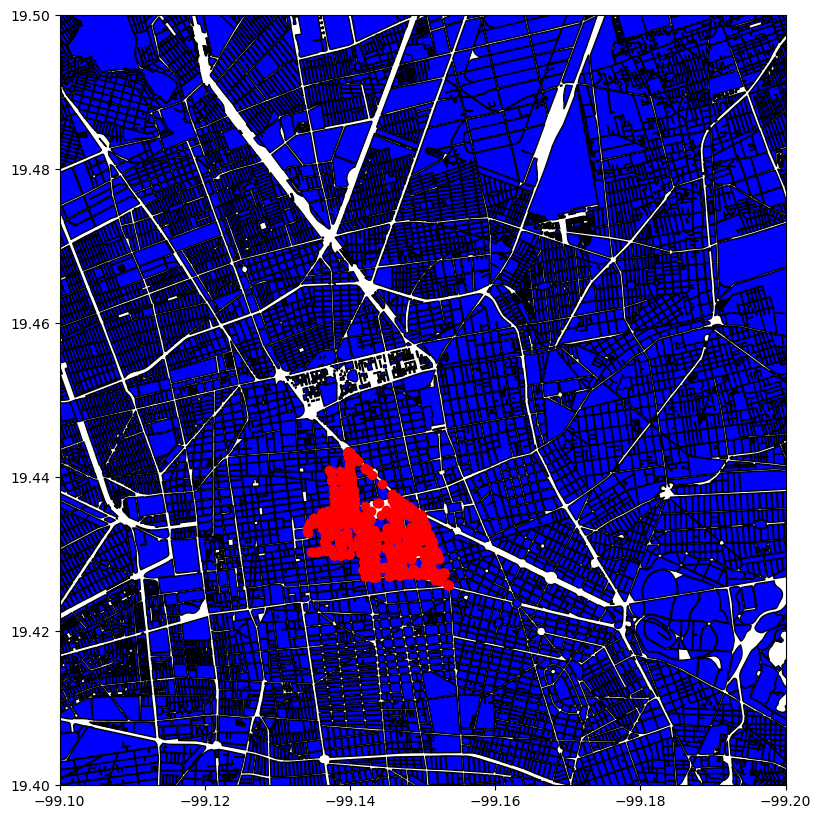

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='black')

# Plot the points
gdf.plot(ax=ax, color='red')

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.10, -99.20])
ax.set_ylim([19.4, 19.5])

plt.show()


## Zoom in more

<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.42, 19.45)

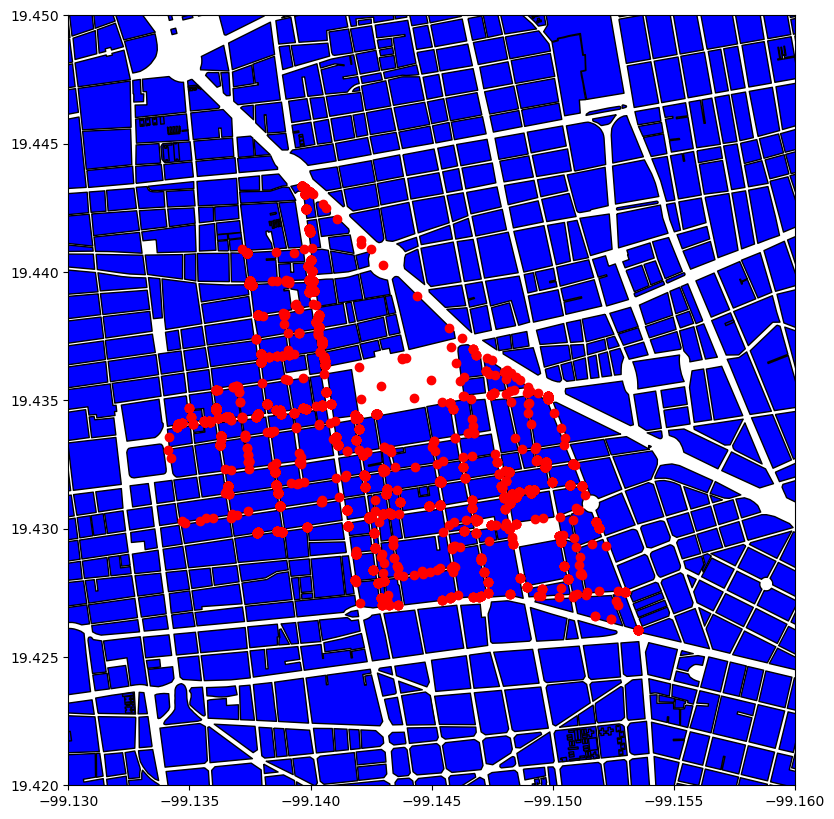

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='black')

# Plot the points
gdf.plot(ax=ax, color='red')

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.42, 19.45])

plt.show()



In [ ]:
gdf.geometry.is_valid.count

In [12]:
print(joined['index_right'].isna().sum())
print(joined['index_right'].count())

7628
4056


<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.42, 19.45)

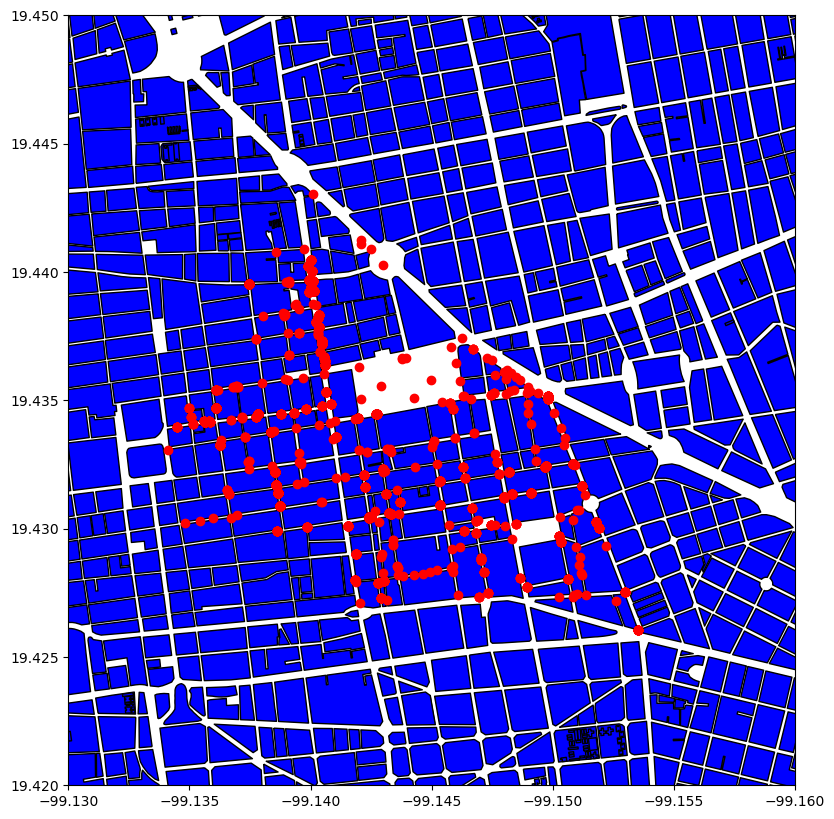

In [15]:
unmatched = gdf[joined['index_right'].isna()]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='black')

# Plot the unmatched points
unmatched.plot(ax=ax, color='red')

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.42, 19.45])
plt.show()



Since the points are falling on the streets and not within the blocks, we will use a buffer around the points to include a surrounding area, which may intersect with the blocks. This can help accommodate points that fall on the streets but are still functionally "within" a block. The currentcoordinate system EPSG:4326, which uses degrees as its unit. This is not the most intuitive approach when trying to create a buffer. We will convert to Universal Transverse Mercator which uses meters instead of degrees. The UTM Zone for Mexico City is EPSG code 32614.

In [16]:
# Convert the CRS of your geodataframes to EPSG:32614
gdf1 = gpd.GeoDataFrame(data, geometry='geometry')
gdf1 = gdf.to_crs(epsg=32614)
blocks = blocks.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf1['geometry'] = gdf1.geometry.buffer(5) # 5 meters as buffer size

# Re-do the spatial join
joined1 = gpd.sjoin(gdf1, blocks, how='left', op='intersects')


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Let's compare NaN values and plot again.

In [32]:
print(joined1['index_right'].isna().sum())
print(joined1['index_right'].count())

1939
10435


<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.42, 19.45)

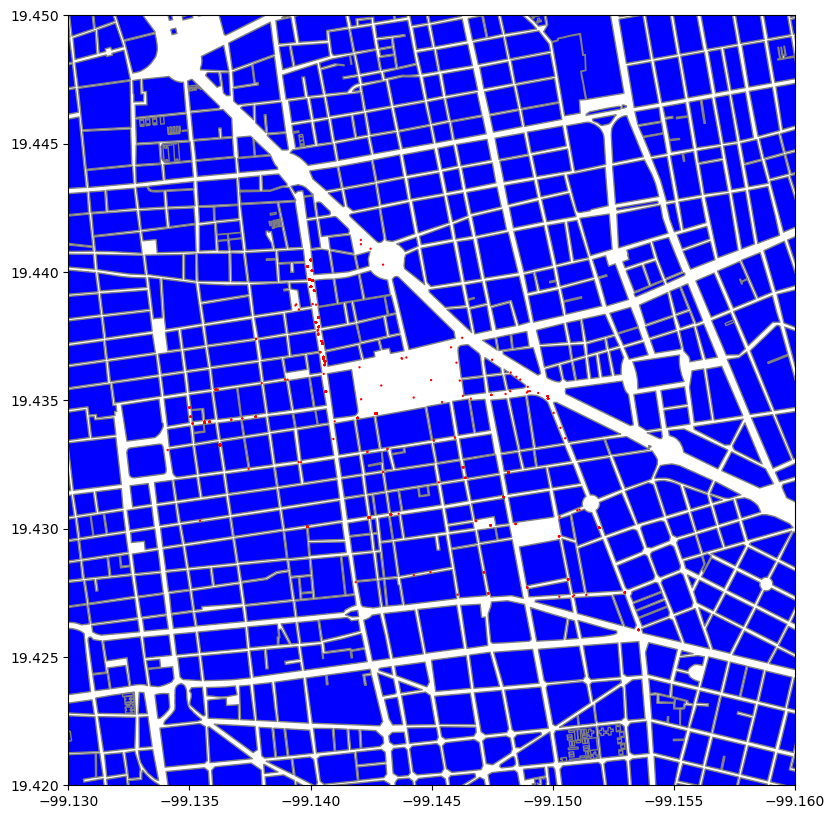

In [49]:
blocks = blocks.to_crs(epsg=4326)


unmatched1 = joined1[joined1['index_right'].isna()]
unmatched1 = unmatched1.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='grey')

# Plot the unmatched points
unmatched1.plot(ax=ax, color='red')
ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.42, 19.45])
plt.show()

We can see that there are few points that are not matched to a block. We will do the join again with a buffer size of 10 meters to assign points on streets to blocks. However, if there are unmatched points after buffer=10, we will not increase the buffer size any further. This is because if the buffer size is too large then points may be assigned to multiple blocks, which would introduce bias into our analysis later on.